# BERT Text Encoder

In this notebook, we will use the BERT model to encode text into vectors. We will use the pre-trained BERT model from the [transformers](https://huggingface.co/docs/transformers/index) library wrapping PyTorch to reuse existing pretrained models.

In [1]:
from transformers import BertTokenizer, BertModel
import torch

In [2]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# Load the pre-trained BERT model.
print('Loading BERT model...')
model = BertModel.from_pretrained('bert-base-uncased')
print('...Done with both.')

Loading BERT tokenizer...
Loading BERT model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


...Done with both.


## Sentences to vectors

In [3]:
# Sentences describing a scene graph
sentences = [
    "A blue chair to the left of a brown wooden table.",
    "A coffee table standing on a blue rug.",
]

In [4]:
test_sentence = sentences[1]

# Print the original sentence.
print(' Original: ', test_sentence)

# Print the sentence split into tokens.
tokens = tokenizer.tokenize(test_sentence)
print(f'Tokenized: {tokens}, tokens: {len(tokens)}')

# Print the sentence mapped to token ids.
ids = tokenizer.convert_tokens_to_ids(tokens)
print(f'Token IDs: {ids}, tokens: {len(ids)}')

# Print the reconstructed sentence from the ids
print(f'Reconstr.: {tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(ids))}')

 Original:  A coffee table standing on a blue rug.
Tokenized: ['a', 'coffee', 'table', 'standing', 'on', 'a', 'blue', 'rug', '.'], tokens: 9
Token IDs: [1037, 4157, 2795, 3061, 2006, 1037, 2630, 20452, 1012], tokens: 9
Reconstr.: a coffee table standing on a blue rug .


In [5]:
# Feed the sentence to BERT and get the hidden states.
input_ids = torch.tensor([tokenizer.encode(test_sentence, add_special_tokens=True)])

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

# Feed the sentence to BERT and get the hidden states.
print('Feeding sentence to BERT...')
with torch.no_grad():
    outputs = model(input_ids)

# (first index extracts the hidden states from a HF wrapper, second index extracts the first sentence from the batch)
embeddings = outputs[0][0]
print(f"Embeddings shape: {embeddings.shape}")

Feeding sentence to BERT...
Embeddings shape: torch.Size([11, 768])


## Batch of words to vectors

In [6]:
words = [
    "chair",
    "table",
    "couch",
    "bed",
    "desk",
    "lamp",
    "rug",
    "pillow",
    "tv",
    "picture",
    "window",
    # "chandelier", # >1 token in BERT
    "painting",
    "carpet",
    "mug",
]

In [7]:
# Feed each word through the tokenizer and get the token ids to convert them back to words for sanity check.
word_ids = [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(word)) for word in words]
reconstructed_words = [tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(word_id)) for word_id in word_ids]

# Print a table of words <> word ids <> returned words
print(f"{'Word':<10} {'Word ID':<10} {'Reconstructed Word':<10}")
print(f"{'-'*10:<10} {'-'*10:<10} {'-'*10:<10}")

for word, word_id, reconstructed_word in zip(words, word_ids, reconstructed_words):
    word_id = ">1 TOKEN" if len(word_id) > 1 else word_id[0]
    print(f"{word:<10} {word_id:<10} {reconstructed_word:<10}")

print(f"{'-'*10:<10} {'-'*10:<10} {'-'*10:<10}")
print(f"Total words: {len(words)}")

Word       Word ID    Reconstructed Word
---------- ---------- ----------
chair      3242       chair     
table      2795       table     
couch      6411       couch     
bed        2793       bed       
desk       4624       desk      
lamp       10437      lamp      
rug        20452      rug       
pillow     10005      pillow    
tv         2694       tv        
picture    3861       picture   
window     3332       window    
painting   4169       painting  
carpet     10135      carpet    
mug        14757      mug       
---------- ---------- ----------
Total words: 14


In [8]:
# Feed all words as a batch to BERT and get the embeddings.
print('Feeding words to BERT...')

model.eval()

with torch.no_grad():
    outputs = model(torch.tensor(word_ids))

word_embeddings = outputs[0].squeeze(1)
print(f"Word embeddings shape: {word_embeddings.shape}")

Feeding words to BERT...
Word embeddings shape: torch.Size([14, 768])


In [9]:
# Print a table of words <> word ids <> embeddings
print(f"{'Word':<10} {'Word ID':<10} {'Embedding':<10}")
print(f"{'-'*10:<10} {'-'*10:<10} {'-'*10:<10}")

for word, word_id, embedding in zip(words, word_ids, word_embeddings):
    word_id = ">1 TOKEN" if len(word_id) > 1 else word_id[0]
    print(f"{word:<10} {word_id:<10} {embedding.tolist()}")

print(f"{'-'*10:<10} {'-'*10:<10} {'-'*10:<10}")
print(f"Total words: {len(words)}")

Word       Word ID    Embedding 
---------- ---------- ----------
chair      3242       [-0.9667339324951172, 0.013892307877540588, 0.43549463152885437, -0.2758113443851471, 0.3039088249206543, 0.3233466148376465, 0.6680510640144348, 0.5430395603179932, -0.37868741154670715, -0.4924848675727844, 0.4745829105377197, -0.5748944282531738, -0.20418037474155426, 0.7415760159492493, -0.6495903730392456, 1.0860356092453003, 0.37213510274887085, -0.39946219325065613, -0.04953456670045853, -0.3206324875354767, -0.2960977554321289, -0.43700119853019714, 0.22767019271850586, -0.2974754571914673, -0.12726755440235138, -0.3491462469100952, -0.4796874523162842, 1.0156983137130737, -0.35555553436279297, 0.04369644820690155, -1.2200006246566772, -0.03232893347740173, -0.04859162122011185, 0.0479389950633049, -0.3230617940425873, -0.11442017555236816, 0.5979803800582886, -0.19167208671569824, -0.6169590950012207, 0.032069720327854156, 0.304299533367157, -0.31141993403434753, 0.1877317875623703, 0.30728

In [10]:
# Compute a similarity matrix between all words.
import numpy as np

similarity_matrix = np.zeros((len(words), len(words)))

for i, embedding_i in enumerate(word_embeddings):
    for j, embedding_j in enumerate(word_embeddings):
        similarity_matrix[i, j] = np.dot(embedding_i, embedding_j) / (np.linalg.norm(embedding_i) * np.linalg.norm(embedding_j))

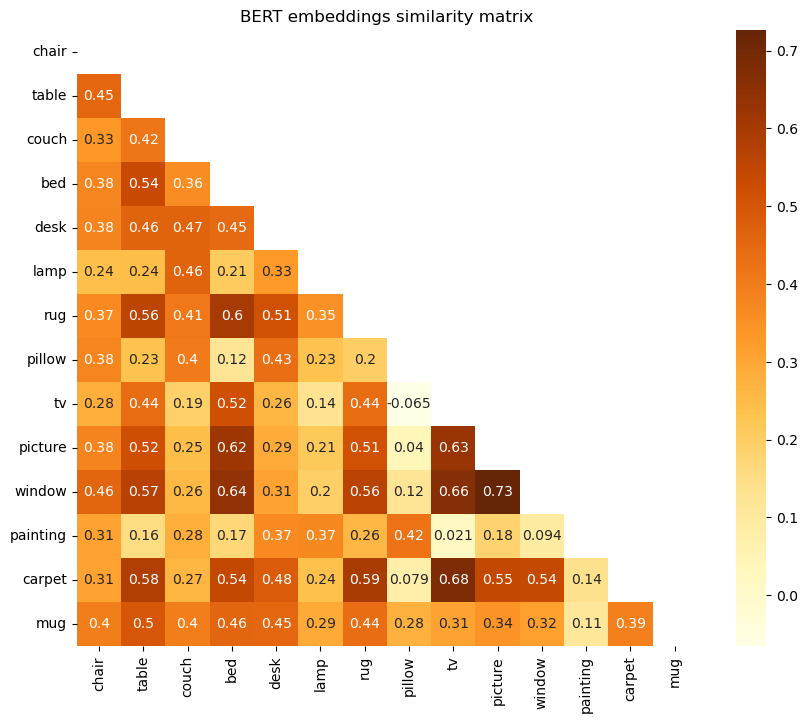

In [11]:
# Print the similarity matrix as a heatmap that highlights the most similar words.
import seaborn as sns
import matplotlib.pyplot as plt

mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=words, yticklabels=words, cmap='YlOrBr', annot=True, mask=mask)
plt.title("BERT embeddings similarity matrix")
plt.show()